<a href="https://colab.research.google.com/github/sergioGarcia91/ML_Carolina_Bays/blob/main/12_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

En este notebookse va predecir para las AOI 02 y AOI 04 considerando los esquemas de 64x64.

# Start

In [ ]:
!pip install tables

In [ ]:
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import h5py
import multiprocessing
import joblib

In [ ]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pathSaveFiguras = '/content/drive/MyDrive/UIS/Doctorado_UIS2198589/1_semestre/TopicosAvanzadosGeofisica/FC_CarolinaBais/Manuscrito_FC/Figuras_Manuscrito/'

## Change Font of the Figures

In [ ]:
!wget https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman.ttf

--2025-11-11 18:20:41--  https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman.ttf
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/justrajdeep/fonts/master/Times%20New%20Roman.ttf [following]
--2025-11-11 18:20:41--  https://raw.githubusercontent.com/justrajdeep/fonts/master/Times%20New%20Roman.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 834452 (815K) [application/octet-stream]
Saving to: ‘Times New Roman.ttf’

Times New Roman.ttf 100%[===================>] 814.89K  --.-KB/s    in 0.06s   

2025-11-11 18:20:41 (12.3 MB/s) - ‘Times New Roman.ttf’ saved [834452/834452]



In [ ]:
import matplotlib.font_manager as fm

In [ ]:
# Path to the custom font
font_path = 'Times New Roman.ttf'

# Add the font to the Matplotlib font manager
font_prop = fm.FontProperties(fname=font_path)
fm.fontManager.addfont(font_path)

# Get the font name to use in rcParams
font_name = font_prop.get_name()
font_name

'Times New Roman'

In [ ]:
plt.rcParams['font.family'] = font_name

# Funtions

## get_rgb

In [ ]:
def get_rgb(tif):
  rgb_image = np.dstack((tif[3],
                         tif[2],
                         tif[1]))
  return rgb_image


## normalize

In [ ]:
def normalize(img, min_percent=2, max_percent=98):
  # Adjusts the image contrast using percentiles.
  p_min, p_max = np.percentile(img, (min_percent, max_percent))
  return np.clip((img - p_min) / (p_max - p_min), 0, 1)


# Load data

In [ ]:
path_save_h5 = '/content/drive/MyDrive/UIS/Doctorado_UIS2198589/1_semestre/TopicosAvanzadosGeofisica/FC_CarolinaBais/Dataset_h5'

h5_file = os.listdir(path_save_h5)
h5_file

['dataset_AOI_01_32x32.h5',
 'dataset_AOI_02_32x32.h5',
 'dataset_AOI_03_32x32.h5',
 'dataset_AOI_04_32x32.h5',
 'dataset_AOI_02_64x64.h5',
 'dataset_AOI_01_64x64.h5',
 'dataset_AOI_03_64x64.h5',
 'dataset_AOI_04_64x64.h5',
 'dataset_AOI_02_256x256.h5',
 'dataset_AOI_03_256x256.h5',
 'dataset_AOI_04_256x256.h5',
 'dataset_AOI_01_256x256.h5']

# AOI

In [ ]:
img = 30000 # 99

# AOI
AOI_name = 'AOI_04'
AOI_ = h5py.File(os.path.join(path_save_h5, f'dataset_{AOI_name}_64x64.h5'), 'r')
AOI_

<HDF5 file "dataset_AOI_04_64x64.h5" (mode r)>

In [ ]:
AOI_[f'{AOI_name}_X'].shape

(94500, 7, 64, 64)

## Plot image

Image 30000


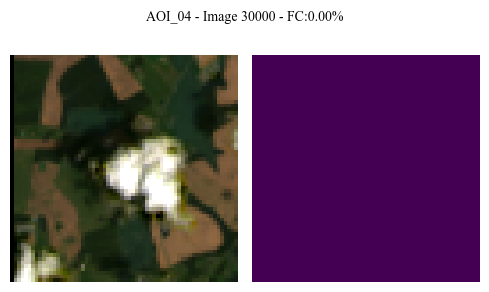

In [ ]:
print(f'Image {img}')
X_ = AOI_[f'{AOI_name}_X'][img]
Y_ = AOI_[f'{AOI_name}_y'][img]
P_ = AOI_[f'{AOI_name}_FC_percentaje'][img]

fig, ax = plt.subplots(figsize=(5, 3), nrows=1, ncols=2)
ax[0].imshow(normalize(get_rgb(X_)))  # Apply normalization
ax[0].axis('off')
ax[1].imshow(Y_, vmin=0, vmax=1)
ax[1].axis('off')

plt.suptitle(f'{AOI_name} - Image {img} - FC:{P_:.2f}%', fontsize=10)
plt.tight_layout()
plt.show()

# X - y df

In [ ]:
X_1 = AOI_[f'{AOI_name}_X'][img]
y_1 = AOI_[f'{AOI_name}_y'][img]

X_1_r = np.reshape(X_1, (7, -1)).T
y_1_r = y_1.reshape(-1,1)

# 64*64 = 4096
print(X_1_r.shape)
print(y_1_r.shape)

(4096, 7)
(4096, 1)


In [ ]:
df = pd.DataFrame(X_1_r, columns=['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7'])

df.head()

,B1,B2,B3,B4,B5,B6,B7
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.049782,0.064028,0.097220,0.125463,0.275200,0.405082,0.241403
2,0.053825,0.067300,0.098265,0.128075,0.275227,0.415148,0.250175
3,0.054870,0.068950,0.099365,0.131320,0.282378,0.424717,0.258425
4,0.055227,0.072030,0.105745,0.144080,0.289362,0.433600,0.266263


## Normalized unit index

In [ ]:
bans = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']

for i in range(len(bans)-1):
  for j in range(i+1, len(bans)):
    b1 = bans[i]
    b2 = bans[j]

    col_name = b2 + '_' + b1
    df[col_name] = ( (df[b2] - df[b1]) / (df[b2] + df[b1]) + 1 ) / 2  # Normalize to [0,1]

df

,B1,B2,B3,B4,B5,B6,B7,B2_B1,B3_B1,B4_B1,...,B4_B3,B5_B3,B6_B3,B7_B3,B5_B4,B6_B4,B7_B4,B6_B5,B7_B5,B7_B6
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.049782,0.064028,0.097220,0.125463,0.275200,0.405082,0.241403,0.562582,0.661349,0.715926,...,0.563414,0.738951,0.806451,0.712896,0.686862,0.763521,0.658015,0.595462,0.467289,0.373408
2,0.053825,0.067300,0.098265,0.128075,0.275227,0.415148,0.250175,0.555624,0.646098,0.704096,...,0.565852,0.736902,0.808604,0.717986,0.682434,0.764231,0.661401,0.601336,0.476159,0.376021
3,0.054870,0.068950,0.099365,0.131320,0.282378,0.424717,0.258425,0.556857,0.644244,0.705301,...,0.569261,0.739707,0.810402,0.722281,0.682570,0.763829,0.663062,0.600651,0.477855,0.378289
4,0.055227,0.072030,0.105745,0.144080,0.289362,0.433600,0.266263,0.566018,0.656913,0.722903,...,0.576724,0.732364,0.803938,0.715745,0.667591,0.750589,0.648879,0.599755,0.479213,0.380450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,0.020110,0.028030,0.083910,0.043403,0.491680,0.223638,0.089658,0.582260,0.806672,0.683369,...,0.340913,0.854219,0.727164,0.516557,0.918886,0.837468,0.673813,0.312641,0.154226,0.286176
4092,0.022943,0.029240,0.068812,0.040378,0.422518,0.204745,0.083690,0.560341,0.749959,0.637674,...,0.369791,0.859946,0.748453,0.548778,0.912772,0.835276,0.674552,0.326410,0.165327,0.290152
4093,0.026325,0.028717,0.059545,0.035152,0.399445,0.196853,0.081793,0.521733,0.693432,0.571795,...,0.371208,0.870269,0.767763,0.578703,0.919115,0.848484,0.699410,0.330125,0.169963,0.293537
4094,0.026517,0.028387,0.047362,0.028085,0.373733,0.166575,0.065953,0.517029,0.641073,0.514354,...,0.372246,0.887525,0.778615,0.582028,0.930105,0.855723,0.701343,0.308297,0.149999,0.283633


In [ ]:
df['y'] = y_1_r
# Replace NaN with 0
df = df.fillna(0)

df.iloc[:100,:]

,B1,B2,B3,B4,B5,B6,B7,B2_B1,B3_B1,B4_B1,...,B5_B3,B6_B3,B7_B3,B5_B4,B6_B4,B7_B4,B6_B5,B7_B5,B7_B6,y
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.049782,0.064028,0.097220,0.125463,0.275200,0.405082,0.241403,0.562582,0.661349,0.715926,...,0.738951,0.806451,0.712896,0.686862,0.763521,0.658015,0.595462,0.467289,0.373408,0.0
2,0.053825,0.067300,0.098265,0.128075,0.275227,0.415148,0.250175,0.555624,0.646098,0.704096,...,0.736902,0.808604,0.717986,0.682434,0.764231,0.661401,0.601336,0.476159,0.376021,0.0
3,0.054870,0.068950,0.099365,0.131320,0.282378,0.424717,0.258425,0.556857,0.644244,0.705301,...,0.739707,0.810402,0.722281,0.682570,0.763829,0.663062,0.600651,0.477855,0.378289,0.0
4,0.055227,0.072030,0.105745,0.144080,0.289362,0.433600,0.266263,0.566018,0.656913,0.722903,...,0.732364,0.803938,0.715745,0.667591,0.750589,0.648879,0.599755,0.479213,0.380450,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.031385,0.042330,0.086770,0.070655,0.449468,0.295660,0.147133,0.574239,0.734374,0.692425,...,0.838187,0.773109,0.629033,0.864157,0.807119,0.675578,0.396791,0.246618,0.332283,0.0
96,0.036968,0.051955,0.091005,0.070902,0.474712,0.278033,0.136242,0.584273,0.711129,0.657296,...,0.839134,0.753399,0.599534,0.870050,0.796803,0.657716,0.369358,0.222999,0.328870,0.0
97,0.047142,0.056080,0.108193,0.085808,0.447652,0.295963,0.155850,0.543292,0.696511,0.645412,...,0.805355,0.732300,0.590246,0.839149,0.775238,0.644921,0.398005,0.258243,0.344944,0.0
98,0.023877,0.031578,0.080720,0.057317,0.373485,0.232300,0.102445,0.569426,0.771720,0.705924,...,0.822283,0.742125,0.559304,0.866952,0.802092,0.641233,0.383469,0.215252,0.306039,0.0


In [ ]:
X_ = df.iloc[:, :-1].to_numpy()
X_.shape

(4096, 28)

# Predicting 75 ML Models

## Load models

In [ ]:
path_models = '/content/drive/MyDrive/UIS/Doctorado_UIS2198589/1_semestre/TopicosAvanzadosGeofisica/FC_CarolinaBais/ML_models'

models_list = os.listdir(path_models)
models_list = [model for model in models_list if model.endswith('.pkl')]
models_list

['model_RegLog_002.pkl',
 'model_RegLog_003.pkl',
 'model_RegLog_004.pkl',
 'model_RegLog_005.pkl',
 'model_RegLog_006.pkl',
 'model_RegLog_007.pkl',
 'model_RegLog_008.pkl',
 'model_RegLog_009.pkl',
 'model_RegLog_010.pkl',
 'model_RegLog_001.pkl',
 'model_RegLog_011.pkl',
 'model_RegLog_012.pkl',
 'model_RegLog_013.pkl',
 'model_RegLog_014.pkl',
 'model_RegLog_015.pkl',
 'model_RegLog_016.pkl',
 'model_RegLog_017.pkl',
 'model_RegLog_018.pkl',
 'model_RegLog_019.pkl',
 'model_RegLog_020.pkl',
 'model_RegLog_021.pkl',
 'model_RegLog_022.pkl',
 'model_RegLog_023.pkl',
 'model_RegLog_024.pkl',
 'model_RegLog_025.pkl',
 'model_RegLog_026.pkl',
 'model_RegLog_027.pkl',
 'model_RegLog_028.pkl',
 'model_RegLog_029.pkl',
 'model_RegLog_030.pkl',
 'model_RandForest_001.pkl',
 'model_RandForest_002.pkl',
 'model_RandForest_003.pkl',
 'model_RandForest_004.pkl',
 'model_RandForest_005.pkl',
 'model_RandForest_006.pkl',
 'model_RandForest_007.pkl',
 'model_RandForest_008.pkl',
 'model_RandForest

## Loop

In [ ]:
df_y_LogReg = df['y'].copy()
df_y_RandForest = df['y'].copy()
df_y_MLP = df['y'].copy()
df_y_MLP_b = df['y'].copy()
df_70_models = df['y'].copy()

In [ ]:
count_models = 1
total_models = len(models_list)
count_LogReg = 1
count_RandForest = 1
count_MLP = 1
count_MLP_b = 1
count_70ML = 1

for model_ in models_list:
  print(f'Model {count_models} of {total_models}')
  print(model_)
  count_models += 1

  model = joblib.load(os.path.join(path_models, model_))

  y_proba = model.predict_proba(X_)[:,1].reshape(-1,1)
  df_70_models = pd.concat([df_70_models, pd.DataFrame(y_proba, columns=[f'y{count_70ML}'])],
                           axis = 1)
  count_70ML += 1

  if 'RegLog' in model_:
    df_y_LogReg = pd.concat([df_y_LogReg, pd.DataFrame(y_proba, columns=[f'y{count_LogReg}'])],
                            axis = 1)
    count_LogReg += 1

  elif 'RandForest' in model_:
    df_y_RandForest = pd.concat([df_y_RandForest, pd.DataFrame(y_proba, columns=[f'y{count_RandForest}'])],
                                axis = 1)
    count_RandForest += 1

  elif 'MLPClassifier' in model_:
    df_y_MLP = pd.concat([df_y_MLP, pd.DataFrame(y_proba, columns=[f'y{count_MLP}'])],
                         axis = 1)
    count_MLP += 1

  elif 'MLP_Classifier' in model_:
    df_y_MLP_b = pd.concat([df_y_MLP_b, pd.DataFrame(y_proba, columns=[f'y{count_MLP_b}'])],
                         axis = 1)
    count_MLP_b += 1

Model 1 of 75
model_RegLog_002.pkl
Model 2 of 75
model_RegLog_003.pkl
Model 3 of 75
model_RegLog_004.pkl
Model 4 of 75
model_RegLog_005.pkl
Model 5 of 75
model_RegLog_006.pkl
Model 6 of 75
model_RegLog_007.pkl
Model 7 of 75
model_RegLog_008.pkl
Model 8 of 75
model_RegLog_009.pkl
Model 9 of 75
model_RegLog_010.pkl
Model 10 of 75
model_RegLog_001.pkl
Model 11 of 75
model_RegLog_011.pkl
Model 12 of 75
model_RegLog_012.pkl
Model 13 of 75
model_RegLog_013.pkl
Model 14 of 75
model_RegLog_014.pkl
Model 15 of 75
model_RegLog_015.pkl
Model 16 of 75
model_RegLog_016.pkl
Model 17 of 75
model_RegLog_017.pkl
Model 18 of 75
model_RegLog_018.pkl
Model 19 of 75
model_RegLog_019.pkl
Model 20 of 75
model_RegLog_020.pkl
Model 21 of 75
model_RegLog_021.pkl
Model 22 of 75
model_RegLog_022.pkl
Model 23 of 75
model_RegLog_023.pkl
Model 24 of 75
model_RegLog_024.pkl
Model 25 of 75
model_RegLog_025.pkl
Model 26 of 75
model_RegLog_026.pkl
Model 27 of 75
model_RegLog_027.pkl
Model 28 of 75
model_RegLog_028.pkl
M

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


Model 38 of 75
model_RandForest_008.pkl
Model 39 of 75
model_RandForest_009.pkl


[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using ba

Model 40 of 75
model_RandForest_010.pkl
Model 41 of 75
model_RandForest_011.pkl
Model 42 of 75
model_RandForest_012.pkl
Model 43 of 75
model_RandForest_013.pkl
Model 44 of 75
model_RandForest_014.pkl
Model 45 of 75
model_RandForest_015.pkl
Model 46 of 75
model_RandForest_016.pkl
Model 47 of 75
model_RandForest_017.pkl
Model 48 of 75
model_RandForest_018.pkl
Model 49 of 75
model_RandForest_019.pkl
Model 50 of 75
model_RandForest_020.pkl


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.0s finished


Model 51 of 75
model_RandForest_021.pkl
Model 52 of 75
model_RandForest_022.pkl
Model 53 of 75
model_RandForest_023.pkl
Model 54 of 75
model_RandForest_024.pkl
Model 55 of 75
model_RandForest_025.pkl
Model 56 of 75
model_RandForest_026.pkl
Model 57 of 75
model_RandForest_027.pkl


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]

Model 58 of 75
model_RandForest_028.pkl
Model 59 of 75
model_RandForest_029.pkl
Model 60 of 75
model_RandForest_030.pkl
Model 61 of 75
model_MLPClassifier_001.pkl
Model 62 of 75
model_MLPClassifier_002.pkl
Model 63 of 75
model_MLPClassifier_003.pkl
Model 64 of 75
model_MLPClassifier_004.pkl
Model 65 of 75
model_MLPClassifier_005.pkl
Model 66 of 75
model_MLPClassifier_006.pkl
Model 67 of 75
model_MLPClassifier_007.pkl


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.0s finished


Model 68 of 75
model_MLPClassifier_008.pkl
Model 69 of 75
model_MLPClassifier_009.pkl
Model 70 of 75
model_MLPClassifier_010.pkl
Model 71 of 75
model_MLP_Classifier_001b.pkl
Model 72 of 75
model_MLP_Classifier_002b.pkl
Model 73 of 75
model_MLP_Classifier_003b.pkl
Model 74 of 75
model_MLP_Classifier_004b.pkl
Model 75 of 75
model_MLP_Classifier_005b.pkl


## DFs

In [ ]:
df_y_LogReg['y_mean'] = df_y_LogReg.iloc[:, 1:].mean(axis=1)
df_y_LogReg['y_std'] = df_y_LogReg.iloc[:, 1:].std(axis=1)
df_y_LogReg.head()

,y,y1,y2,y3,y4,y5,y6,y7,y8,y9,...,y23,y24,y25,y26,y27,y28,y29,y30,y_mean,y_std
0,0.0,0.000004,0.000004,0.000005,0.000004,0.000004,0.000005,0.000005,0.000005,0.000004,...,0.000004,0.000005,0.000005,0.000005,0.000005,0.000005,0.000004,0.000004,0.000004,3.167682e-07
1,0.0,0.381415,0.382472,0.382441,0.382189,0.379950,0.383034,0.380721,0.381606,0.381015,...,0.381761,0.381572,0.380801,0.382282,0.382170,0.382727,0.381928,0.381685,0.381735,7.454994e-04
2,0.0,0.382069,0.383189,0.383156,0.382810,0.380527,0.383632,0.381378,0.382273,0.381683,...,0.382407,0.382248,0.381440,0.382882,0.382981,0.383445,0.382556,0.382382,0.382421,7.616850e-04
3,0.0,0.387339,0.388460,0.388403,0.388034,0.385645,0.388803,0.386551,0.387467,0.386868,...,0.387556,0.387422,0.386735,0.388129,0.388237,0.388698,0.387690,0.387544,0.387634,7.715367e-04
4,0.0,0.347471,0.348330,0.348265,0.347964,0.345479,0.348638,0.346444,0.347392,0.346795,...,0.347449,0.347256,0.346918,0.348262,0.348068,0.348557,0.347605,0.347354,0.347534,7.564240e-04


In [ ]:
df_y_RandForest['y_mean'] = df_y_RandForest.iloc[:, 1:].mean(axis=1)
df_y_RandForest['y_std'] = df_y_RandForest.iloc[:, 1:].std(axis=1)
df_y_RandForest.head()

,y,y1,y2,y3,y4,y5,y6,y7,y8,y9,...,y23,y24,y25,y26,y27,y28,y29,y30,y_mean,y_std
0,0.0,0.161096,0.149177,0.122471,0.152600,0.143227,0.150965,0.151973,0.141843,0.125947,...,0.129656,0.148234,0.130992,0.129823,0.140868,0.115765,0.155879,0.144193,0.138549,0.013943
1,0.0,0.429225,0.447989,0.440085,0.446659,0.429494,0.446710,0.445049,0.453123,0.444801,...,0.450137,0.421193,0.436267,0.441152,0.434391,0.440771,0.452175,0.433959,0.437975,0.009587
2,0.0,0.429225,0.453139,0.440085,0.446659,0.429494,0.446710,0.445049,0.453123,0.444801,...,0.450137,0.421193,0.436267,0.441152,0.434391,0.440771,0.452175,0.443130,0.437834,0.010192
3,0.0,0.429225,0.448785,0.447155,0.446659,0.433389,0.437759,0.445049,0.453731,0.444801,...,0.454785,0.419714,0.436267,0.441152,0.439503,0.440771,0.452175,0.443130,0.438243,0.010232
4,0.0,0.429225,0.444323,0.440085,0.446659,0.420647,0.436532,0.445049,0.453731,0.444801,...,0.450137,0.419714,0.436267,0.441152,0.434391,0.440771,0.452175,0.433959,0.435893,0.010153


In [ ]:
df_y_MLP['y_mean'] = df_y_MLP.iloc[:, 1:].mean(axis=1)
df_y_MLP['y_std'] = df_y_MLP.iloc[:, 1:].std(axis=1)
df_y_MLP.head()

,y,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,y_mean,y_std
0,0.0,1.102807e-14,1.662773e-10,1.676670e-07,0.000011,0.000002,4.487249e-11,0.012720,0.000022,0.272544,0.000039,0.028534,0.081425
1,0.0,3.261687e-01,3.652038e-01,3.953980e-01,0.399486,0.307173,3.423677e-01,0.409391,0.440066,0.389580,0.376251,0.375109,0.038460
2,0.0,3.127600e-01,3.570014e-01,3.542138e-01,0.398383,0.288101,3.323748e-01,0.395550,0.429489,0.375560,0.361863,0.360530,0.040019
3,0.0,2.883895e-01,3.188097e-01,3.193463e-01,0.373879,0.271596,3.322796e-01,0.380512,0.435038,0.364578,0.354367,0.343879,0.045562
4,0.0,2.619416e-01,2.104599e-01,3.174672e-01,0.336924,0.249416,3.284790e-01,0.364834,0.448374,0.364442,0.351648,0.323399,0.064860


In [ ]:
df_y_MLP_b['y_mean'] = df_y_MLP_b.iloc[:, 1:].mean(axis=1)
df_y_MLP_b['y_std'] = df_y_MLP_b.iloc[:, 1:].std(axis=1)
df_y_MLP_b.head()

,y,y1,y2,y3,y4,y5,y_mean,y_std
0,0.0,0.016319,3.565455e-34,0.000004,2.155171e-11,3.489966e-10,0.003265,0.006527
1,0.0,0.528816,4.427995e-01,0.526573,4.513133e-01,4.325577e-01,0.476412,0.042297
2,0.0,0.517524,4.307896e-01,0.523713,4.394778e-01,4.165806e-01,0.465617,0.045542
3,0.0,0.501375,4.136111e-01,0.521714,4.358888e-01,4.019904e-01,0.454916,0.047937
4,0.0,0.488849,3.932772e-01,0.518736,4.377872e-01,3.823481e-01,0.444199,0.052932


In [ ]:
df_70_models['y_mean'] = df_70_models.iloc[:, 1:].mean(axis=1)
df_70_models['y_std'] = df_70_models.iloc[:, 1:].std(axis=1)
df_70_models.head()

,y,y1,y2,y3,y4,y5,y6,y7,y8,y9,...,y68,y69,y70,y71,y72,y73,y74,y75,y_mean,y_std
0,0.0,0.000004,0.000004,0.000005,0.000004,0.000004,0.000005,0.000005,0.000005,0.000004,...,0.000022,0.272544,0.000039,0.016319,3.565455e-34,0.000004,2.155171e-11,3.489966e-10,0.059443,0.072240
1,0.0,0.381415,0.382472,0.382441,0.382189,0.379950,0.383034,0.380721,0.381606,0.381015,...,0.440066,0.389580,0.376251,0.528816,4.427995e-01,0.526573,4.513133e-01,4.325577e-01,0.409659,0.037978
2,0.0,0.382069,0.383189,0.383156,0.382810,0.380527,0.383632,0.381378,0.382273,0.381683,...,0.429489,0.375560,0.361863,0.517524,4.307896e-01,0.523713,4.394778e-01,4.165806e-01,0.407214,0.039147
3,0.0,0.387339,0.388460,0.388403,0.388034,0.385645,0.388803,0.386551,0.387467,0.386868,...,0.435038,0.364578,0.354367,0.501375,4.136111e-01,0.521714,4.358888e-01,4.019904e-01,0.406529,0.041190
4,0.0,0.347471,0.348330,0.348265,0.347964,0.345479,0.348638,0.346444,0.347392,0.346795,...,0.448374,0.364442,0.351648,0.488849,3.932772e-01,0.518736,4.377872e-01,3.823481e-01,0.386104,0.055902


# Plot predictions

## Logistic Regression

Image 30000


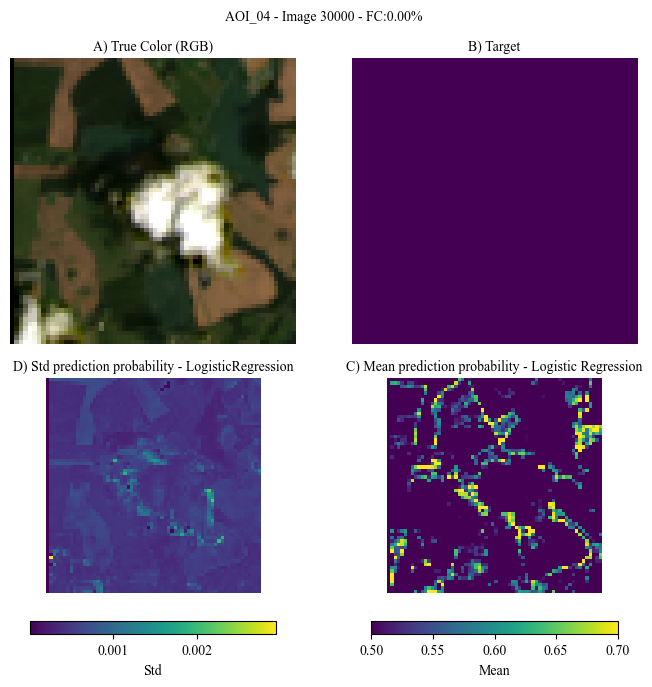

In [ ]:
print(f'Image {img}')
X_ = AOI_[f'{AOI_name}_X'][img]
Y_ = AOI_[f'{AOI_name}_y'][img]
P_ = AOI_[f'{AOI_name}_FC_percentaje'][img]

mean_plot = df_y_LogReg['y_mean'].values.reshape(X_.shape[1:])
std_plot = df_y_LogReg['y_std'].values.reshape(X_.shape[1:])

fig, ax = plt.subplots(figsize=(7, 7), nrows=2, ncols=2)
ax[0,0].imshow(normalize(get_rgb(X_)))  # Apply normalization
ax[0,0].axis('off')
ax[0,1].imshow(Y_, vmin=0, vmax=1)
ax[0,1].axis('off')

im = ax[1,0].imshow(std_plot)  # Apply normalization
ax[1,0].axis('off')

cbar = fig.colorbar(im, ax=ax[1,0],
                    orientation='horizontal',
                    pad=0.1,
                    shrink=0.75)
cbar.set_label('Std')

im = ax[1,1].imshow(mean_plot, vmin=0.5, vmax=0.7)
ax[1,1].axis('off')
cbar = fig.colorbar(im, ax=ax[1,1],
                    orientation='horizontal',
                    pad=0.1,
                    shrink=0.75)
cbar.set_label('Mean')

ax[0,0].set_title('A) True Color (RGB)', fontsize= 10)
ax[0,1].set_title('B) Target', fontsize= 10)
ax[1,1].set_title('C) Mean prediction probability - Logistic Regression', fontsize= 10)
ax[1,0].set_title('D) Std prediction probability - LogisticRegression', fontsize= 10)

plt.suptitle(f'{AOI_name} - Image {img} - FC:{P_:.2f}%', fontsize=10)
plt.tight_layout()

plt.savefig((pathSaveFiguras + f'Figura_LogReg_{AOI_name}.png'),
            format='png', dpi=1000, bbox_inches = 'tight',pad_inches=0.25)

plt.show()

## Random Forest Classifier

Image 30000


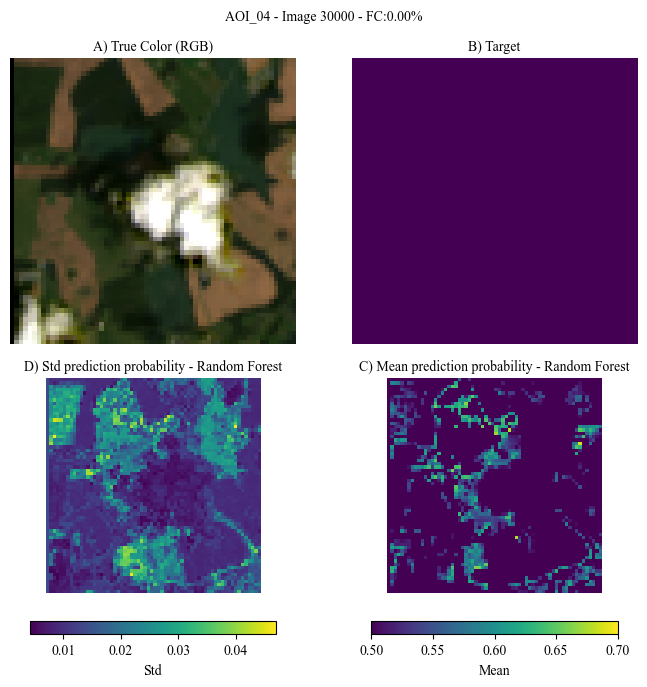

In [ ]:
print(f'Image {img}')
X_ = AOI_[f'{AOI_name}_X'][img]
Y_ = AOI_[f'{AOI_name}_y'][img]
P_ = AOI_[f'{AOI_name}_FC_percentaje'][img]

mean_plot = df_y_RandForest['y_mean'].values.reshape(X_.shape[1:])
std_plot = df_y_RandForest['y_std'].values.reshape(X_.shape[1:])

fig, ax = plt.subplots(figsize=(7, 7), nrows=2, ncols=2)
ax[0,0].imshow(normalize(get_rgb(X_)))  # Apply normalization
ax[0,0].axis('off')
ax[0,1].imshow(Y_, vmin=0, vmax=1)
ax[0,1].axis('off')

im = ax[1,0].imshow(std_plot)  # Apply normalization
ax[1,0].axis('off')

cbar = fig.colorbar(im, ax=ax[1,0],
                    orientation='horizontal',
                    pad=0.1,
                    shrink=0.75)
cbar.set_label('Std')

im = ax[1,1].imshow(mean_plot, vmin=0.5, vmax=0.7)
ax[1,1].axis('off')
cbar = fig.colorbar(im, ax=ax[1,1],
                    orientation='horizontal',
                    pad=0.1,
                    shrink=0.75)
cbar.set_label('Mean')

ax[0,0].set_title('A) True Color (RGB)', fontsize= 10)
ax[0,1].set_title('B) Target', fontsize= 10)
ax[1,1].set_title('C) Mean prediction probability - Random Forest', fontsize= 10)
ax[1,0].set_title('D) Std prediction probability - Random Forest', fontsize= 10)

plt.suptitle(f'{AOI_name} - Image {img} - FC:{P_:.2f}%', fontsize=10)
plt.tight_layout()

plt.savefig((pathSaveFiguras + f'Figura_RanFor_{AOI_name}.png'),
            format='png', dpi=1000, bbox_inches = 'tight',pad_inches=0.25)

plt.show()

## MLPClassifier

Image 30000


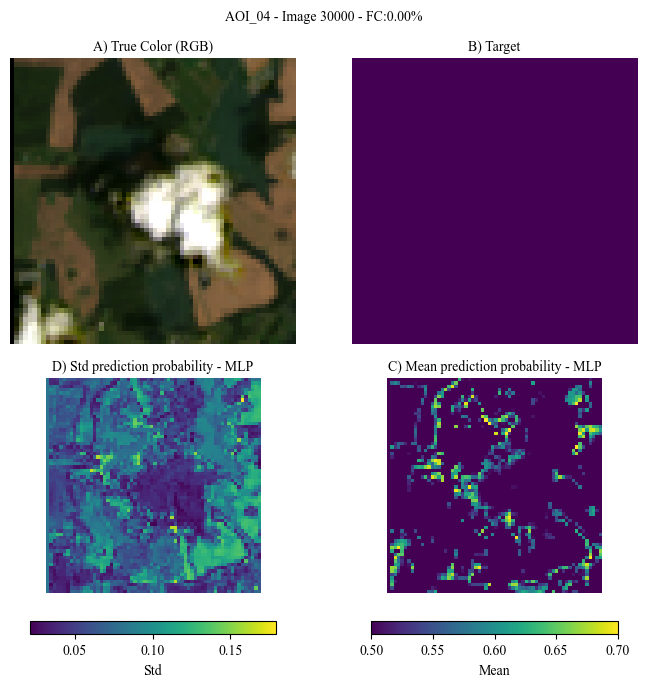

In [ ]:
print(f'Image {img}')
X_ = AOI_[f'{AOI_name}_X'][img]
Y_ = AOI_[f'{AOI_name}_y'][img]
P_ = AOI_[f'{AOI_name}_FC_percentaje'][img]

mean_plot = df_y_MLP['y_mean'].values.reshape(X_.shape[1:])
std_plot = df_y_MLP['y_std'].values.reshape(X_.shape[1:])

fig, ax = plt.subplots(figsize=(7, 7), nrows=2, ncols=2)
ax[0,0].imshow(normalize(get_rgb(X_)))  # Apply normalization
ax[0,0].axis('off')
ax[0,1].imshow(Y_, vmin=0, vmax=1)
ax[0,1].axis('off')

im = ax[1,0].imshow(std_plot)  # Apply normalization
ax[1,0].axis('off')

cbar = fig.colorbar(im, ax=ax[1,0],
                    orientation='horizontal',
                    pad=0.1,
                    shrink=0.75)
cbar.set_label('Std')

im = ax[1,1].imshow(mean_plot, vmin=0.5, vmax=0.7)
ax[1,1].axis('off')
cbar = fig.colorbar(im, ax=ax[1,1],
                    orientation='horizontal',
                    pad=0.1,
                    shrink=0.75)
cbar.set_label('Mean')

ax[0,0].set_title('A) True Color (RGB)', fontsize= 10)
ax[0,1].set_title('B) Target', fontsize= 10)
ax[1,1].set_title('C) Mean prediction probability - MLP', fontsize= 10)
ax[1,0].set_title('D) Std prediction probability - MLP', fontsize= 10)

plt.suptitle(f'{AOI_name} - Image {img} - FC:{P_:.2f}%', fontsize=10)
plt.tight_layout()

plt.savefig((pathSaveFiguras + f'Figura_MLPCLass_a_{AOI_name}.png'),
            format='png', dpi=1000, bbox_inches = 'tight',pad_inches=0.25)

plt.show()

## MLPClassifier_b

Image 30000


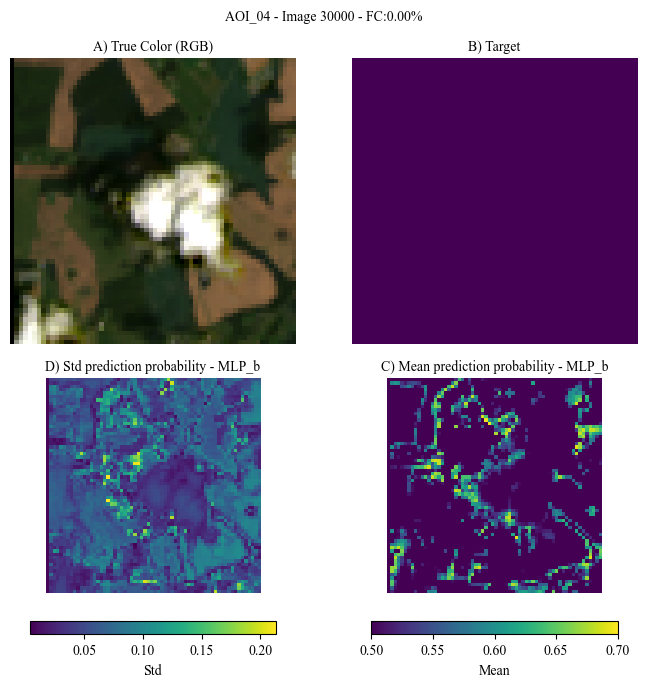

In [ ]:
print(f'Image {img}')
X_ = AOI_[f'{AOI_name}_X'][img]
Y_ = AOI_[f'{AOI_name}_y'][img]
P_ = AOI_[f'{AOI_name}_FC_percentaje'][img]

mean_plot = df_y_MLP_b['y_mean'].values.reshape(X_.shape[1:])
std_plot = df_y_MLP_b['y_std'].values.reshape(X_.shape[1:])

fig, ax = plt.subplots(figsize=(7, 7), nrows=2, ncols=2)
ax[0,0].imshow(normalize(get_rgb(X_)))  # Apply normalization
ax[0,0].axis('off')
ax[0,1].imshow(Y_, vmin=0, vmax=1)
ax[0,1].axis('off')

im = ax[1,0].imshow(std_plot)  # Apply normalization
ax[1,0].axis('off')

cbar = fig.colorbar(im, ax=ax[1,0],
                    orientation='horizontal',
                    pad=0.1,
                    shrink=0.75)
cbar.set_label('Std')

im = ax[1,1].imshow(mean_plot, vmin=0.5, vmax=0.7)
ax[1,1].axis('off')
cbar = fig.colorbar(im, ax=ax[1,1],
                    orientation='horizontal',
                    pad=0.1,
                    shrink=0.75)
cbar.set_label('Mean')

ax[0,0].set_title('A) True Color (RGB)', fontsize= 10)
ax[0,1].set_title('B) Target', fontsize= 10)
ax[1,1].set_title('C) Mean prediction probability - MLP_b', fontsize= 10)
ax[1,0].set_title('D) Std prediction probability - MLP_b', fontsize= 10)

plt.suptitle(f'{AOI_name} - Image {img} - FC:{P_:.2f}%', fontsize=10)
plt.tight_layout()

plt.savefig((pathSaveFiguras + f'Figura_MLPCLass_b_{AOI_name}.png'),
            format='png', dpi=1000, bbox_inches = 'tight',pad_inches=0.25)

plt.show()

## 75 models

Image 30000


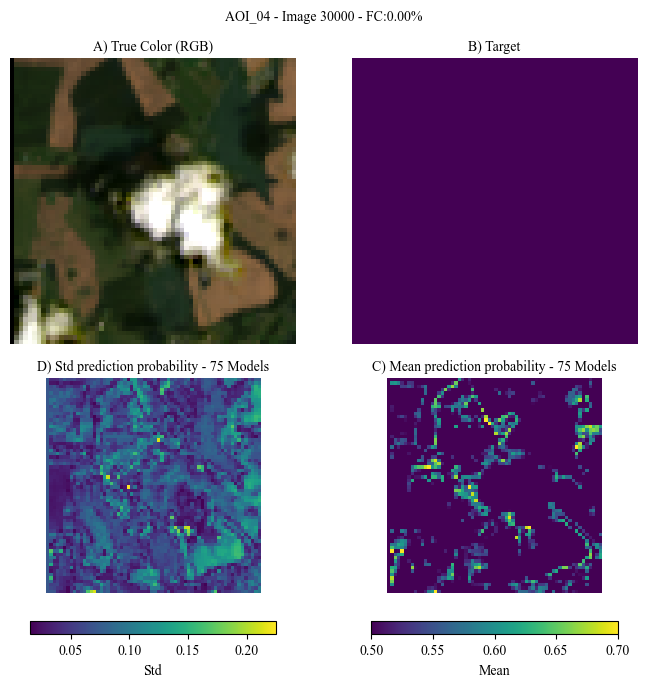

In [ ]:
print(f'Image {img}')
X_ = AOI_[f'{AOI_name}_X'][img]
Y_ = AOI_[f'{AOI_name}_y'][img]
P_ = AOI_[f'{AOI_name}_FC_percentaje'][img]

mean_plot = df_70_models['y_mean'].values.reshape(X_.shape[1:])
std_plot = df_70_models['y_std'].values.reshape(X_.shape[1:])

fig, ax = plt.subplots(figsize=(7, 7), nrows=2, ncols=2)
ax[0,0].imshow(normalize(get_rgb(X_)))  # Apply normalization
ax[0,0].axis('off')
ax[0,1].imshow(Y_, vmin=0, vmax=1)
ax[0,1].axis('off')

im = ax[1,0].imshow(std_plot)  # Apply normalization
ax[1,0].axis('off')

cbar = fig.colorbar(im, ax=ax[1,0],
                    orientation='horizontal',
                    pad=0.1,
                    shrink=0.75)
cbar.set_label('Std')

im = ax[1,1].imshow(mean_plot, vmin=0.5, vmax=0.7)
ax[1,1].axis('off')
cbar = fig.colorbar(im, ax=ax[1,1],
                    orientation='horizontal',
                    pad=0.1,
                    shrink=0.75)
cbar.set_label('Mean')

ax[0,0].set_title('A) True Color (RGB)', fontsize= 10)
ax[0,1].set_title('B) Target', fontsize= 10)
ax[1,1].set_title('C) Mean prediction probability - 75 Models', fontsize= 10)
ax[1,0].set_title('D) Std prediction probability - 75 Models', fontsize= 10)

plt.suptitle(f'{AOI_name} - Image {img} - FC:{P_:.2f}%', fontsize=10)
plt.tight_layout()

plt.savefig((pathSaveFiguras + f'Figura_75models_{AOI_name}.png'),
            format='png', dpi=1000, bbox_inches = 'tight',pad_inches=0.25)

plt.show()

# End